# Importo librerias

In [1]:
import os

# Obtener el directorio de trabajo actual
current_working_directory = os.getcwd()

# Mostrar el directorio de trabajo actual
print("El directorio de trabajo actual es:", current_working_directory)


El directorio de trabajo actual es: c:\lab02\DMA_LAB2\Notebooks


In [2]:
import numpy as np 
import pandas as pd 
# import cv2 #Para cargar/mostrar/procesar imagenes
import json
import glob #Para listar los archivos en una carpeta

# Librerias propias (contienen los modelos)
import model_metadata
import model_sentiment



# Codigo Auxiliar

In [3]:
#Para borrar la cache de las librerias propias
#import importlib
#importlib.reload(model_sentiment)
#importlib.reload(model_metadata)

# Cargo archivos

## Primer analisis:

Cargo el dataset completo y para el ID **0a0e8c15b** cargo las imagenes que tiene, metadata de las imagenes y analisis de sentimiento de la descripcion.

In [4]:
#No ejecutar
# Cargar CSV train de carpeta data/train/train.csv
bandera = False
if bandera:
    train_data = pd.read_csv('../data/train/train.csv', index_col='PetID')
    train_image_1 = cv2.imread('../data/train_images/0a0e8c15b-1.jpg')
    train_image_2 = cv2.imread('../data/train_images/0a0e8c15b-2.jpg')
    with open('../data/train_metadata/0a0e8c15b-1.json', 'r') as archivo:
        # Carga el contenido del archivo JSON en un diccionario
        train_metadata_1 = json.load(archivo)
    with open('../data/train_metadata/0a0e8c15b-2.json', 'r') as archivo:
        # Carga el contenido del archivo JSON en un diccionario
        train_metadata_2 = json.load(archivo)
    with open('../data/train_sentiment/0a0e8c15b.json', 'r') as archivo:
        # Carga el contenido del archivo JSON en un diccionario
        train_sentiment = json.load(archivo)

Creo una funcion para importar los archivos json a una lista. Los archivos los modelo y los inserto en una lista.

In [5]:
def getModel(model, listFileFullPath):
    '''model = clase del modelo que se quiere cargar (objeto)
    listFullPath = ruta completa de los archivos a cargar (List[string])
    '''
    #f_train_metadata = glob.glob('../data/train_metadata/*.json')
    #f_train_sentiments = glob.glob('../data/train_sentiment/*.json')

    listObject = []
    for file in listFileFullPath:
        
        file_json = None
        objectModel = None
        
        with open(file, 'r') as archivo:
            file_json = json.load(archivo)    

        fileName = file.split('/')[-1]
        file_json['fileName'] = fileName
        file_json['PetID'] = fileName.split('.')[0].split('-')[0]
        objectModel = model.Model(**file_json)
        listObject.append(objectModel)

    return listObject 

In [7]:
train_data = pd.read_csv('../data/train/train.csv', index_col='PetID')

In [8]:
#train_data = pd.read_csv('../data/train/train.csv', index_col='PetID')
f_train_metadata = glob.glob('../data/train_metadata/*.json')
f_train_sentiments = glob.glob('../data/train_sentiment/*.json')

list_metadata = getModel(model_metadata, f_train_metadata)
list_sentiments = getModel(model_sentiment, f_train_sentiments)

del f_train_metadata
del f_train_sentiments

## Unifico dataset e informacion extra

En esta seccion vamos a agregar informacion exta al dataset original. Vamos a agregar las siguientes variables:

De la imagen:

1. Imagen? [SI/NO] Si la mascata tiene imagen 1 sino 0. **(LISTO)**
2. ImagenCantidad Cantidad de imagenes que posee la mascota. **(LISTO)**

Del Comentario:
1. magnitude. **(LISTO)**
2. score. **(LISTO)**
3. Cantidad de sentencias. **(LISTO)**
4. EntidadCantidad. **(LISTO)**
5. Entidad por tipo (son varias columnas). **(PENDIENTE)**
6. El nombre de la mascota figura como entidad?. **(PENDIENTE)**
7. Idioma. **(PENDIENTE)**

Datos descriptivos: **(PENDIENTE)**
1. Agregar Beed
2. Agregar Color
3. Agregar PetFinder
4. Agregar state


## Creamos funciones para obtener propiedades de los modelos

In [9]:
# Creo funciones para obtener datos de los modelos

##Sirve para cualquiera de l0s dos modelos
getPetID = lambda x: x.PetID
getPetID_vec = np.vectorize(getPetID)

#Solo para la modelo model_sentiment
#1. magnitude
#2. score
#3. Cantidad de sentencias
#4. EntidadCantidad

getScore = lambda x: x.documentSentiment.score
getScore_vec = np.vectorize(getScore)

getMagnitude = lambda x: x.documentSentiment.magnitude
getMagnitude_vec = np.vectorize(getMagnitude)

getLenEntity = lambda x: len(x.entities)
getLenEntity_vec = np.vectorize(getLenEntity)

getLenSentences = lambda x: len(x.sentences)
getLenSentences_vec = np.vectorize(getLenSentences)


## Agregamos variables al dataset original

In [10]:
#Si tiene o no metadata de la imagen
train_data['Imagen?'] = train_data.index.isin(getPetID_vec(list_metadata))
#Si tiene o no archivo sentiment
train_data['sentiment?'] = train_data.index.isin(getPetID_vec(list_sentiments))

#Busco la cantidad de imagenes y las agrego al DF original
df = pd.DataFrame(getPetID_vec(list_metadata))
df = df[0].value_counts()
df.columns = ['PetID', 'CountImagen']
train_data = train_data.join(df, on='PetID', how='left', lsuffix='_left', rsuffix='_right')
del df

#Agrego informacion de los archivo sentiment
df = pd.DataFrame(
        data = {'Score' : getScore_vec(list_sentiments).tolist()
                ,'Magnitude' : getMagnitude_vec(list_sentiments).tolist()
                ,'CountEntity' : getLenEntity_vec(list_sentiments).tolist()
                ,'CountSentences' : getLenSentences_vec(list_sentiments).tolist()
                }
        , index=getPetID_vec(list_sentiments))

df.index.name = 'PetID'

train_data = train_data.join(df, on='PetID', how='left', lsuffix='_left', rsuffix='_right')
del df


# EDA

In [11]:
# Para validar (no ejecutar)
#Buscar archivo por linea de comando
#find . -type f -name "*86e1089a3*"
#find . -type f -name "*1bc0f89d8*"
#1bc0f89d8 
#train_data[train_data['Imagen?'] == False].head(10)
#train_data[train_data['sentiment?'] == True].head(10)
train_data.head(10)


,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,...,Description,PhotoAmt,AdoptionSpeed,Imagen?,sentiment?,count,Score,Magnitude,CountEntity,CountSentences
PetID,,,,,,,,,,,,,,,,,,,,,
86e1089a3,2,Nibble,3,299,0,1,1,7,0,1,...,Nibble is a 3+ month old ball of cuteness. He ...,1.0,2,False,False,NaN,NaN,NaN,NaN,NaN
6296e909a,2,No Name Yet,1,265,0,1,1,2,0,2,...,I just found it alone yesterday near my apartm...,2.0,0,False,False,NaN,NaN,NaN,NaN,NaN
3422e4906,1,Brisco,1,307,0,1,2,7,0,2,...,Their pregnant mother was dumped by her irresp...,7.0,3,False,False,NaN,NaN,NaN,NaN,NaN
5842f1ff5,1,Miko,4,307,0,2,1,2,0,2,...,"Good guard dog, very alert, active, obedience ...",8.0,2,False,False,NaN,NaN,NaN,NaN,NaN
850a43f90,1,Hunter,1,307,0,1,1,0,0,2,...,This handsome yet cute boy is up for adoption....,3.0,2,False,False,NaN,NaN,NaN,NaN,NaN
d24c30b4b,2,NaN,3,266,0,2,5,6,0,2,...,This is a stray kitten that came to my house. ...,2.0,2,False,False,NaN,NaN,NaN,NaN,NaN
1caa6fcdb,2,BULAT,12,264,264,1,1,0,0,2,...,anyone within the area of ipoh or taiping who ...,3.0,1,False,False,NaN,NaN,NaN,NaN,NaN
97aa9eeac,1,Siu Pak & Her 6 Puppies,0,307,0,2,1,2,7,2,...,Siu Pak just give birth on 13/6/10 to 6puppies...,9.0,3,False,False,NaN,NaN,NaN,NaN,NaN
c06d167ca,2,NaN,2,265,0,2,6,0,0,2,...,"healthy and active, feisty kitten found in nei...",6.0,1,False,False,NaN,NaN,NaN,NaN,NaN


## Pre-procesar Nulos

Verificar la existencia de Nulos y decidir como Imputarlos en caso de que existan

Verificar la existencia de Ceros u otros valores que puedan indicar que pueden ser perdidos

### Nulos

In [12]:
#Verificar la existencia de Nulos en train_date y decidir como Imputarlos en caso de que existan
rta = train_data.isnull().sum()
#imprimir solo los que tienen nulos
rta[rta > 0]

Name               1265
Description          13
count             14993
Score             14993
Magnitude         14993
CountEntity       14993
CountSentences    14993
dtype: int64

*count es cantidad de imagen

Los nombres tienen null (esto no seria un problema). Por otro lado el resto de las variables que estan null son las variables que generamos desde los archivos, es decir, tienen null porque no poseen archivo para esos PetID.

### Ceros

In [13]:
#Verificar la existencia de ceros en train_date y decidir como Imputarlos en caso de que existan
rta = (train_data == 0).sum()
#imprimir solo los que tienen ceros
rta[rta > 0]

Age                179
Breed1               5
Breed2           10762
Color2            4471
Color3           10604
Fee              12663
VideoAmt         14419
PhotoAmt           341
AdoptionSpeed      410
Imagen?          14993
sentiment?       14993
dtype: int64

| Variable|Cantida Cero | Observacion
| ----------------|-------|--------------
| Age             |   179 | (Valor posible) 
| Breed1          |     5 | No existe descripcion para estos casos
| Breed2          | 10762 | No existe descripcion para estos casos
| Color2          |  4471 | No existe descripcion para estos casos
| Color3          | 10604 | No existe descripcion para estos casos
| Fee             | 12663 | (Valor posible) Fee - Adoption fee (0 = Free)
| VideoAmt        | 14419 | (Valor posible) Videos subidos para la mascota
| PhotoAmt        |   341 | (Valor posible) Fotos subidos para la mascota
| AdoptionSpeed   |   410 | (Valor posible)
| Imagen?         |   341 | (Valor posible)
| sentiment?      |   551 | (Valor posible)
| Score           |  2328 | (Valor posible)
| Magnitude       |   596 | (Valor posible)
| CountEntity     |   273 | (Valor posible)

<Axes: >

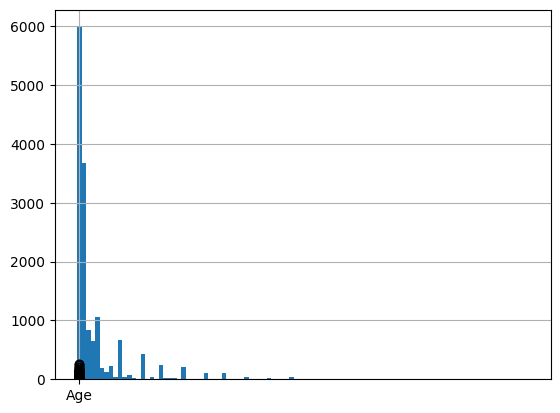

In [14]:
#graficar la distribucion de la variable a Age y un diagrama de caja y bigotes
#Quiero que el grafico sea animado
#https://towardsdatascience.com/creating-animated-gif-using-python-opencv-31f5bbf27d9c
#https://stackoverflow.com/questions/44947505/how-to-make-a-gif-loop-in-python
#https://stackoverflow.com/questions/753190/programmatically-generate-video-or-animated-gif-in-python   

train_data['Age'].hist(bins=100)
train_data.boxplot(column=['Age'])

In [15]:
# generar una tabla resumen de train_data con cantidad de registros, cantidad de requistros que poseen imagen (imagen?) y cantidad de registros que poseen sentimientos (sentiment?)

cantidadRegistros = train_data.shape[0]
print(f'Cantidad de registros: {cantidadRegistros}')
print(f'Cantidad de registros con imagen: {train_data["Imagen?"].sum()}')
print(f'Cantidad de registros sin imagen: {cantidadRegistros - train_data["Imagen?"].sum()}')
print(f'Cantidad de registros con sentimientos: {train_data["sentiment?"].sum()}')
print(f'Cantidad de registros sin sentimientos: {cantidadRegistros - train_data["sentiment?"].sum()}')

Cantidad de registros: 14993
Cantidad de registros con imagen: 0
Cantidad de registros sin imagen: 14993
Cantidad de registros con sentimientos: 0
Cantidad de registros sin sentimientos: 14993


In [16]:
#import dtale
#dtale.show(train_data)
#http://localhost:40000/
